In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve
from tqdm import tqdm
import xgboost as xgb #BDT
import pickle
import mplhep as hep

from utils.analysis import Optimization

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
babies = glob.glob("../analysis/studies/vbsvvhjets/output_new/Run2/*.root")
babies = [baby for baby in babies if "data" not in baby]
babies

['../analysis/studies/vbsvvhjets/output_new/Run2/TTW.root',
 '../analysis/studies/vbsvvhjets/output_new/Run2/TTHad.root',
 '../analysis/studies/vbsvvhjets/output_new/Run2/SingleTop.root',
 '../analysis/studies/vbsvvhjets/output_new/Run2/QCD.root',
 '../analysis/studies/vbsvvhjets/output_new/Run2/TTH.root',
 '../analysis/studies/vbsvvhjets/output_new/Run2/Bosons.root',
 '../analysis/studies/vbsvvhjets/output_new/Run2/TT1L.root',
 '../analysis/studies/vbsvvhjets/output_new/Run2/VBSVVH.root']

In [3]:
vbsvvh = Optimization(
    sig_root_files=babies[-1:],
    bkg_root_files=babies[:-1],
    ttree_name="tree",
    weight_columns=[
        "xsec_sf", 
        "pu_sf",
        "prefire_sf"
    ]
)

Loading bkg babies: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:07<00:00,  1.07s/it]


In [4]:
vbsvvh.sig_count(
    selection=(
        "M_jj > 500 and abs(deta_jj) > 3"
        + "and hbbfatjet_score > 0.9"
        + "and ld_vqqfatjet_score > 0.9 and tr_vqqfatjet_score > 0.9"
        + "and ST > 1300"
        + "and hbbfatjet_mass < 150"
        + "and ld_vqqfatjet_mass < 120 and tr_vqqfatjet_mass < 120"
    )
)

3.5580299543254306

In [5]:
vbsvvh.bkg_count(
    selection=(
        "M_jj > 500 and abs(deta_jj) > 3"
        + "and hbbfatjet_score > 0.9"
        + "and ld_vqqfatjet_score > 0.9 and tr_vqqfatjet_score > 0.9"
        + "and ST > 1300"
        + "and hbbfatjet_mass < 150"
        + "and ld_vqqfatjet_mass < 120 and tr_vqqfatjet_mass < 120"
    )
)

3.6252976984997805

In [6]:
vbsvvh.make_selection(
    "ST > 1300"
    + "and hbbfatjet_score > 0.5"
    + "and ld_vqqfatjet_score > 0.5 and tr_vqqfatjet_score > 0.5"
    + "and ld_vqqfatjet_mass < 120 and tr_vqqfatjet_mass < 120"
    + "and hbbfatjet_mass < 150"
)
vbsvvh.set_split_column(ratio=0.6, name="split")

In [7]:
vbsvvh.sample_df("TTHad").event_weight.sum()

134.14146747498893

In [8]:
vbsvvh.sample_df("QCD").event_weight.sum()

622.2523286974744

In [9]:
vbsvvh.sig_count()

9.676079796989004

In [10]:
vbsvvh.df.columns

Index(['reweight_c2v_eq_3', 'HT', 'n_jets', 'n_loose_b_jets',
       'n_medium_b_jets', 'n_tight_b_jets', 'btag_sf', 'btag_sf_up',
       'btag_sf_dn', 'n_fatjets', 'ld_vbsjet_pt', 'ld_vbsjet_eta',
       'ld_vbsjet_phi', 'tr_vbsjet_pt', 'tr_vbsjet_eta', 'tr_vbsjet_phi',
       'M_jj', 'deta_jj', 'abs_deta_jj', 'dR_jj', 'xsec_sf', 'pu_sf',
       'pu_sf_up', 'pu_sf_dn', 'prefire_sf', 'prefire_sf_up', 'prefire_sf_dn',
       'trig_sf', 'trig_sf_up', 'trig_sf_dn', 'event', 'MET', 'MET_up',
       'MET_dn', 'lhe_muF0p5_muR0p5', 'lhe_muF1p0_muR0p5', 'lhe_muF2p0_muR0p5',
       'lhe_muF0p5_muR1p0', 'lhe_muF1p0_muR1p0', 'lhe_muF2p0_muR1p0',
       'lhe_muF0p5_muR2p0', 'lhe_muF1p0_muR2p0', 'lhe_muF2p0_muR2p0',
       'ps_isr2p0_fsr1p0', 'ps_isr1p0_fsr2p0', 'ps_isr0p5_fsr1p0',
       'ps_isr1p0_fsr0p5', 'ld_vqqfatjet_score', 'ld_vqqfatjet_pt',
       'ld_vqqfatjet_eta', 'ld_vqqfatjet_phi', 'ld_vqqfatjet_mass',
       'ld_vqqfatjet_msoftdrop', 'tr_vqqfatjet_score', 'tr_vqqfatjet_pt',
       'tr

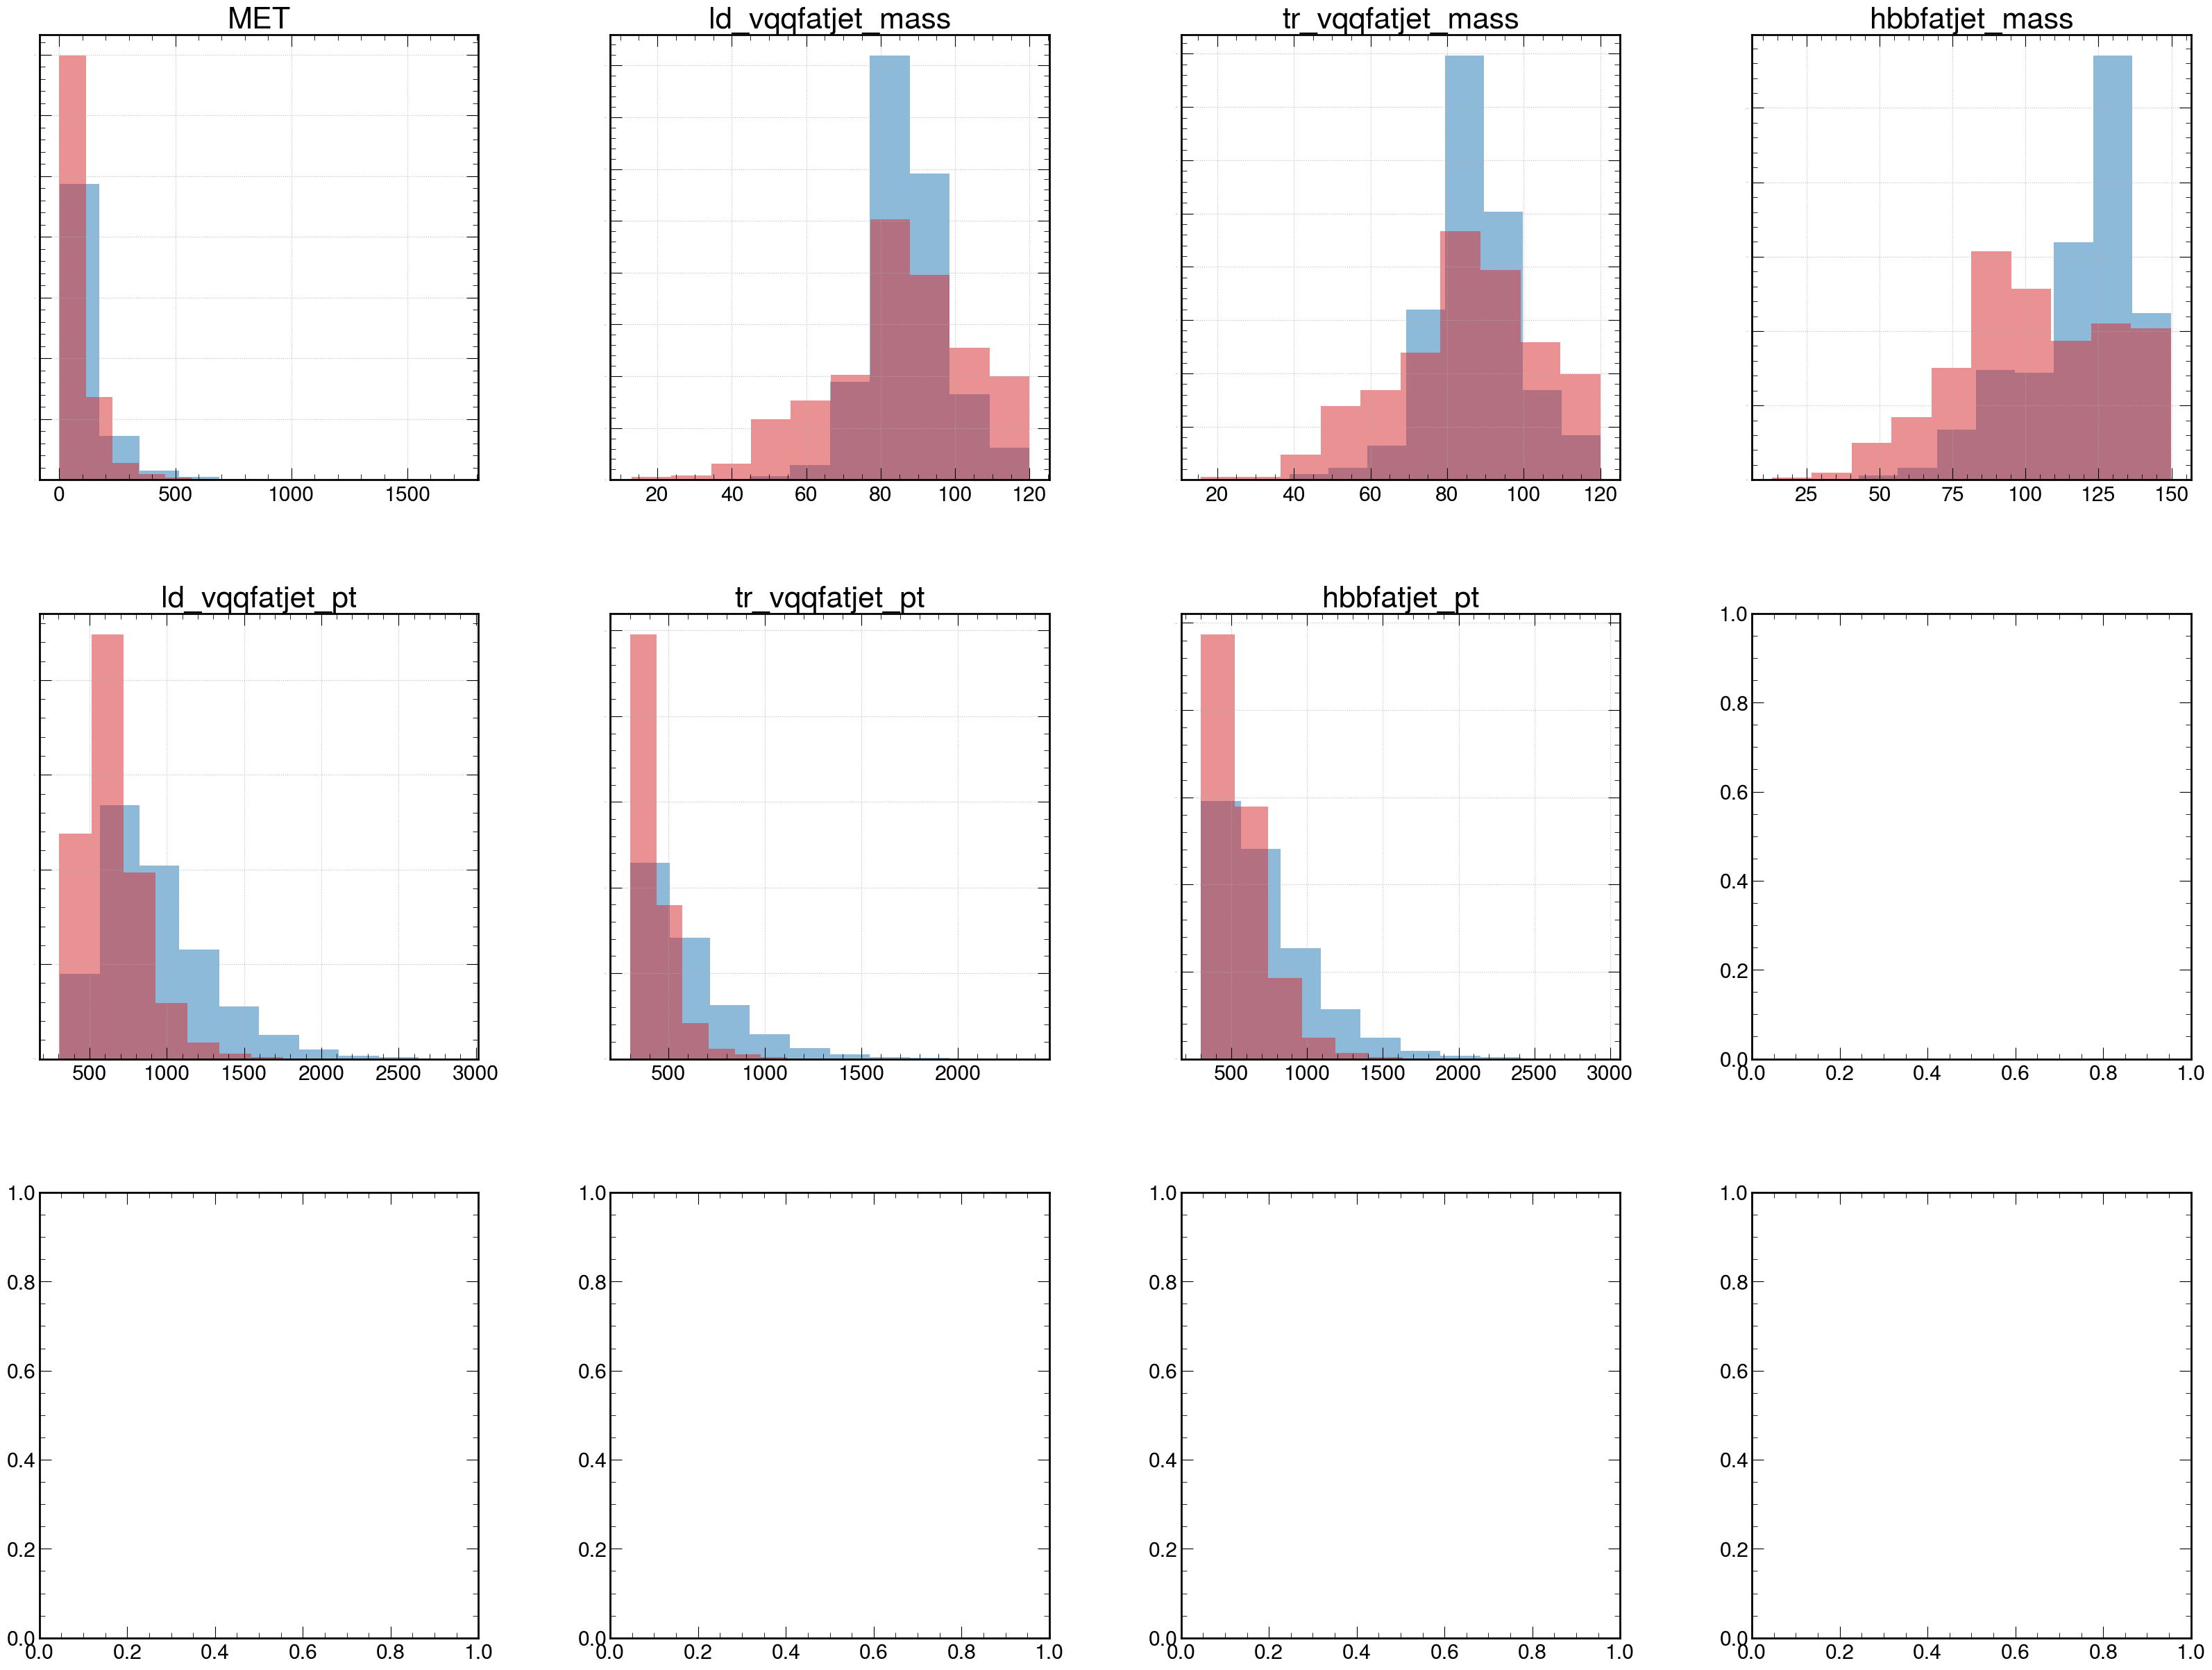

In [11]:
# Select features
features = [
    "MET",
#     "ld_vqqfatjet_score",
#     "tr_vqqfatjet_score",
#     "hbbfatjet_score",
    "ld_vqqfatjet_mass",
    "tr_vqqfatjet_mass",
    "hbbfatjet_mass",
#     "ST",
    "ld_vqqfatjet_pt",
    "tr_vqqfatjet_pt",
    "hbbfatjet_pt",
]

# Plot feature shapes
fig, axes = plt.subplots(3,4,figsize=(40,30))

sig_df = vbsvvh.sig_df()
bkg_df = vbsvvh.bkg_df()

ax = sig_df[features].hist(
    ax=axes.flatten()[:len(features)],
    alpha=0.5, color="C0", ylabelsize=0, 
    density=True
)
ax = bkg_df[features].hist(
    ax=axes.flatten()[:len(features)], 
    alpha=0.5, color="C3", ylabelsize=0, 
    density=True
)

In [12]:
train_df = vbsvvh.df[vbsvvh.df.split].sample(frac=1.)
test_df = vbsvvh.df[~vbsvvh.df.split].sample(frac=1.)

# BDT input
dtest = xgb.DMatrix(
    test_df[features], 
    label=test_df.is_signal,
    weight=np.abs(test_df.split_weight)
)
dtrain = xgb.DMatrix(
    train_df[features], 
    label=train_df.is_signal, 
    weight=np.abs(train_df.split_weight)
)
evallist = [(dtrain, "train"), (dtest, "eval")]

# BDT parameters setup
params = {}
params["objective"] = "binary:logistic"

# BDT knobs (hyper-parameters)
num_round = 500                  # Number of training rounds
params["eta"] = 0.1              # Step size shrinkage (alias: learning_rate)
params["max_depth"] = 3          # Max. depth of tree: larger = more complex = more prone to overfitting
params["verbosity"] = 1          # 0 (silent), 1 (warning), 2 (info), 3 (debug)
params["nthread"] = 8            # Number of parallel threads
params["eval_metric"] = "auc"    # Evaluation metrics for validation data. 'auc' = Area Under the [ROC] Curve
params["subsample"] = 0.6        # Subsample ratio of the training instances
params["alpha"] = 8.0            # L1 regularization term on weights: Larger = more conservative
params["gamma"] = 2.0            # Min. loss rediction to make leaf (alias: min_split_loss)
params["lambda"] = 1.0           # L2 regularization term on weights: Larger = more conservative
params["min_child_weight"] = 1.0 # Minimum sum of instance weight (hessian) needed in a child
params["colsample_bytree"] = 1.0 # The subsample ratio of columns when constructing each tree
# params["base_score"] = 0.1       # The initial prediction score of all instances, global bias

# Get pos/neg weights
sumw_pos = np.abs(dtrain.get_weight()[dtrain.get_label() == 1]).sum()
sumw_neg = np.abs(dtrain.get_weight()[dtrain.get_label() == 0]).sum()
# Control the balance of positive and negative weights, useful for unbalanced classes
# A typical value to consider: sum(negative instances) / sum(positive instances)
params["scale_pos_weight"] = sumw_neg/sumw_pos

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [13]:
bst = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds=10, verbose_eval=True)

[0]	train-auc:0.84970	eval-auc:0.84742
[1]	train-auc:0.86910	eval-auc:0.86813
[2]	train-auc:0.88526	eval-auc:0.88552
[3]	train-auc:0.89957	eval-auc:0.89777
[4]	train-auc:0.90102	eval-auc:0.89826
[5]	train-auc:0.90521	eval-auc:0.90410
[6]	train-auc:0.91188	eval-auc:0.91034
[7]	train-auc:0.91897	eval-auc:0.91796
[8]	train-auc:0.92148	eval-auc:0.92011
[9]	train-auc:0.92185	eval-auc:0.92133
[10]	train-auc:0.92708	eval-auc:0.92676
[11]	train-auc:0.92708	eval-auc:0.92692
[12]	train-auc:0.92764	eval-auc:0.92792
[13]	train-auc:0.92808	eval-auc:0.92922
[14]	train-auc:0.93165	eval-auc:0.93297
[15]	train-auc:0.93216	eval-auc:0.93405
[16]	train-auc:0.93312	eval-auc:0.93479
[17]	train-auc:0.93541	eval-auc:0.93659
[18]	train-auc:0.93801	eval-auc:0.93924
[19]	train-auc:0.93873	eval-auc:0.93990
[20]	train-auc:0.94018	eval-auc:0.94166
[21]	train-auc:0.94065	eval-auc:0.94215
[22]	train-auc:0.94100	eval-auc:0.94234
[23]	train-auc:0.94210	eval-auc:0.94337
[24]	train-auc:0.94222	eval-auc:0.94380
[25]	train

In [14]:
# Get predictions
preds_train = bst.predict(xgb.DMatrix(train_df[features]))
preds_test = bst.predict(xgb.DMatrix(test_df[features]))

y_train = train_df.is_signal
y_test = test_df.is_signal

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Preliminary'))

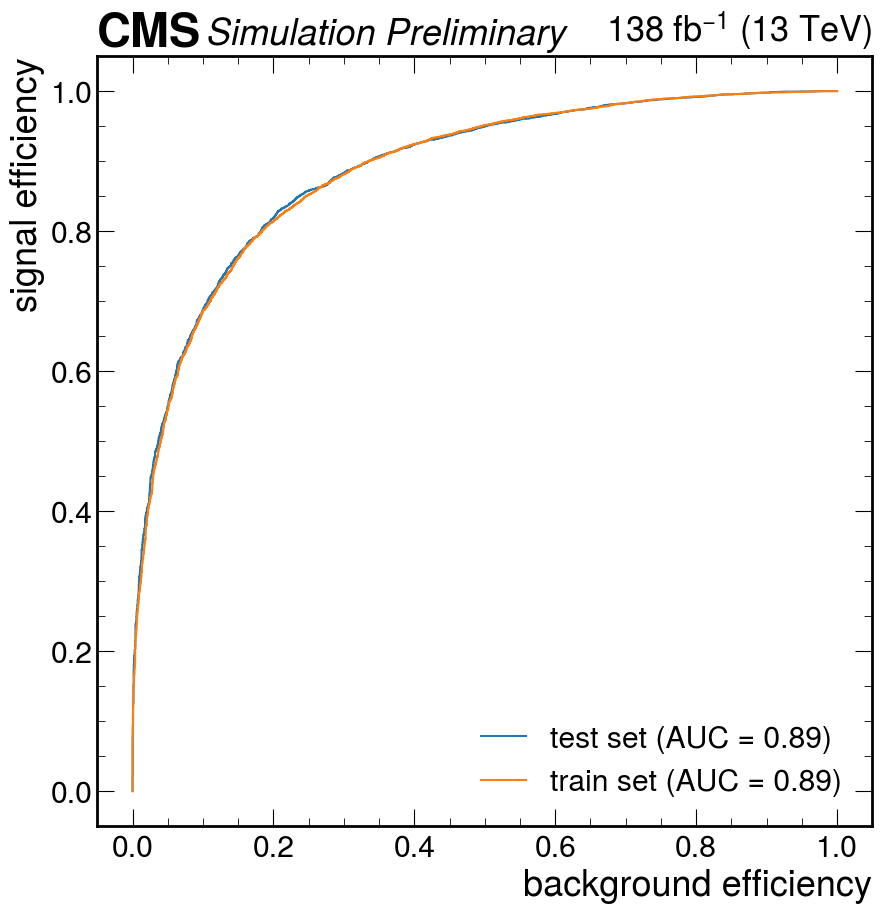

In [15]:
fig, axes = plt.subplots()

# Test ROC Curve
fpr, tpr, thresh = roc_curve(test_df.is_signal, preds_test)
plt.plot(fpr, tpr, label="test set (AUC = {:.2f})".format(np.trapz(tpr,fpr)));

# Train ROC Curve
fpr, tpr, thresh = roc_curve(train_df.is_signal, preds_train)
plt.plot(fpr, tpr, label="train set (AUC = {:.2f})".format(np.trapz(tpr,fpr)));

plt.xlabel("background efficiency");
plt.ylabel("signal efficiency");
plt.legend();

hep.cms.label("Preliminary", data=False, lumi=138, loc=0, ax=axes)

In [16]:
vbsvvh.df["bdt"] = bst.predict(xgb.DMatrix(vbsvvh.df[features]))

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


<AxesSubplot:xlabel='BDT Score', ylabel='Events'>

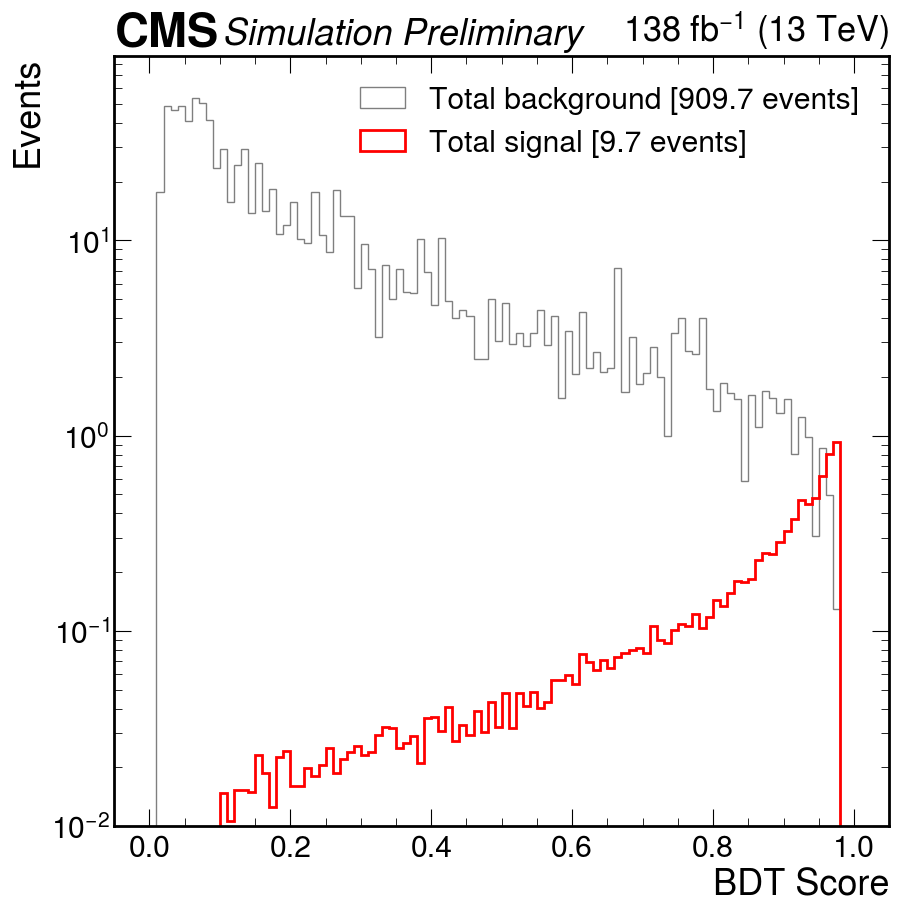

In [17]:
vbsvvh.plot_sig_vs_bkg("bdt", np.linspace(0, 1, 101), x_label="BDT Score", logy=True)

In [18]:
vbsvvh.fom_scan(
    "bdt", [0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94], 
    base_selection="M_jj > 500 and abs(deta_jj) > 3", 
    show_raw=True
)

sel,sig,,bkg,,fom
M_jj > 500 and abs(deta_jj) > 3,8.805810928567691,16190,285.5180614380611,2703,0.5211377856177849
M_jj > 500 and abs(deta_jj) > 3 and bdt > 0.8,5.888129824122254,10577,7.382835113831159,224,2.1670343347826537
M_jj > 500 and abs(deta_jj) > 3 and bdt > 0.85,5.167158439364123,9252,5.301601825955196,150,2.2441311022942565
M_jj > 500 and abs(deta_jj) > 3 and bdt > 0.9,4.062695532761808,7250,2.523662412375015,77,2.5573999179005114
M_jj > 500 and abs(deta_jj) > 3 and bdt > 0.91,3.7707939606736236,6695,1.8714013602293873,66,2.7564450070840283
M_jj > 500 and abs(deta_jj) > 3 and bdt > 0.92,3.4434899242161574,6078,1.6883398427785736,51,2.6501403945847883
M_jj > 500 and abs(deta_jj) > 3 and bdt > 0.93,3.0156290314635497,5313,1.2902312297007983,37,2.6548753842296886
M_jj > 500 and abs(deta_jj) > 3 and bdt > 0.94,2.612072982637719,4580,0.9832984891204524,21,2.6341628543408704


In [19]:
for key, val in params.items():
    print(f"{key},{val}")

objective,binary:logistic
eta,0.1
max_depth,3
verbosity,1
nthread,8
eval_metric,auc
subsample,0.6
alpha,8.0
gamma,2.0
lambda,1.0
min_child_weight,1.0
colsample_bytree,1.0
scale_pos_weight,95.0549087524414


In [20]:
# Write features list
with open("../analysis/studies/vbsvvhjets/vbsvvhjets_bdt/bdt_features.txt", "w") as txt_file:
    txt_file.write("\n".join(features))

# Write BDT model
pickle.dump(bst, open("../analysis/studies/vbsvvhjets/vbsvvhjets_bdt/bdt.pkl", "wb"))
bst.save_model("../analysis/studies/vbsvvhjets/vbsvvhjets_bdt/bdt.model")
bst.dump_model(
    "../analysis/studies/vbsvvhjets/vbsvvhjets_bdt/bdt.json", 
    "../analysis/studies/vbsvvhjets/vbsvvhjets_bdt/bdt_features.txt"
)